In [30]:
import os
import json
import pandas as pd
import re

# 给定用户目录, 获取所有结果目录的函数
def get_all_results(dir_of_results):
    # 获取用户目录下的所有目录
    dirs = os.listdir(dir_of_results)
    # 用于存放所有结果目录的列表
    results_dirs = []
    # 遍历所有目录
    for dir in dirs:
        # 判断是否是目录
        if os.path.isdir(os.path.join(dir_of_results, dir)):
            # 是目录, 添加到列表中
            results_dirs.append(dir)
    # 返回结果目录列表
    return results_dirs


'''
这是一个config.json文件的例子  
{
    "defense_method": "FLUD",
    "batch_size": 128,
    "attack_method": "NoAttack",
    "local_epochs": 10,
    "local_learning_rate": 0.1,
    "num_clients": 20,
    "num_classess": 10,
    "join_ratio": 1,
    "dataset": "/scratch/wenjie/processed_data/FashionMNIST_iid-False_alpha-1_numclients-20_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/",
    "global_rounds": 50,
    "given_size": 4096
}
'''


def extract_dataset_name(path):
    # 定义一个正则表达式模式，匹配 'MNIST', 'FashionMNIST', 或 'CIFAR10'
    pattern = r"(MNIST|FashionMNIST|CIFAR10)"
    match = re.search(pattern, path)
    if match:
        return match.group(0)  # 返回匹配的字符串
    else:
        return None  # 如果没有找到匹配，返回None
    
def extract_alpha(path):
    # 定义一个正则表达式模式，匹配 'alpha-1' 或 'alpha-0.1'
    pattern = r"alpha-(\d+(\.\d+)?)"
    match = re.search(pattern, path)
    if match:
        return float(match.group(1))  # 返回匹配的字符串
    else:
        return None  # 如果没有找到匹配，返回None

def extract_iid_bool(path):
    # 定义一个正则表达式模式，匹配 'iid-True' 或 'iid-False'
    pattern = r"iid-(True|False)"
    match = re.search(pattern, path)
    if match:
        return match.group(1) == 'True'  # 返回匹配的字符串
    else:
        return None  # 如果没有找到匹配，返回None

# 读取config.json文件的函数
def read_config_json(dir):
    dict_config = {}
    # 读取config.json文件
    with open(os.path.join(dir_of_results, dir, 'config.json'), 'r') as f:
        config = json.load(f)
    # 需要返回一个字典, defense_method, attack_method, dataset, alpha
    dict_config['defense_method'] = config['defense_method']
    dict_config['attack_method'] = config['attack_method']
    # dict_config['dataset'] 为 /scratch/wenjie/processed_data/FashionMNIST_iid中的MNIST or FashionMNIST or CIFAR10
    dict_config['dataset'] = extract_dataset_name(config['dataset'])
    dict_config['alpha'] = extract_alpha(config['dataset'])
    dict_config['iid'] = extract_iid_bool(config['dataset'])
    
    # dict_config转为dataframe
    df = pd.DataFrame(dict_config, index=[0])
    return df

''' reslut.json文件的一行的例子
{"training_iteration": 49, "acc_top_1": 0.6663, "test_asr": 0.044333333333333336, "train_loss": {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 1.2119735522746025, "9": 0.2515048308054074, "10": 0.15761679203715176, "11": 0.17082774190011582, "12": 0.10106942657310153, "13": 0.27020537603918154, "14": 0.04544255931293827, "15": 0.1475819638608733, "16": 0.2246073077452214, "17": 0.12518050659127766, "18": 0.2522706906469962, "19": 1.0126364003358916}}
'''
# 读取result.json文件, 并且返回一个dataframe的函数
def read_all_result_json(dir):
    # 读取result.json文件
    with open(os.path.join(dir_of_results, dir, 'result.json'), 'r') as f:
        results = f.readlines()
    # 用于存放所有结果的列表
    list_results = []
    # 遍历所有行
    for result in results:
        # 将json字符串转换为字典
        dict_result = json.loads(result)
        # 用于存放一行结果的列表
        list_result = []
        # 依次添加到列表中
        list_result.append(dict_result['training_iteration'])
        list_result.append(dict_result['acc_top_1'])
        list_result.append(dict_result['test_asr'])
        # list_result.append(dict_result['train_loss'])
        # 添加到结果列表中
        list_results.append(list_result)
    # 将结果列表转换为dataframe
    df = pd.DataFrame(list_results, columns=['training_iteration', 'acc_top_1', 'test_asr'])
    return df

# 读取result.json文件, 只返回最后一行的函数
def read_last_result_json(dir):
    # 读取result.json文件
    with open(os.path.join(dir_of_results, dir, 'result.json'), 'r') as f:
        results = f.readlines()
    # 将最后一行json字符串转换为字典
    dict_result = json.loads(results[-1])

    # 如果是BackdoorAttack, 则返回 第 25 轮的结果
    if 'Backdoor' in dir:
        dict_result = json.loads(results[24])
    # 用于存放一行结果的列表
    list_result = []
    # 依次添加到列表中
    list_result.append(dict_result['training_iteration'])
    list_result.append(dict_result['acc_top_1'])
    list_result.append(dict_result['test_asr'])
    # 将列表转换为dataframe
    df = pd.DataFrame([list_result], columns=['training_iteration', 'acc_top_1', 'test_asr'])
    return df

# 存放所有结果目录的用户目录
dir_of_results = os.path.expanduser('~/results_iid_noniid')

dirs = get_all_results(dir_of_results)


df = pd.DataFrame()

# 读取config.json文件, 并且读取result.json文件
for dir in dirs:
    tmp = pd.DataFrame()
    # 读取config.json文件
    df_config = read_config_json(dir)
    # 检查是否有nan
    if df_config.isnull().values.any():
        continue
    # 读取result.json文件, 只返回最后一行
    df_result_last_row = read_last_result_json(dir)
    # 检查是否有nan
    if df_result_last_row.isnull().values.any():
        continue
    # 合并config和result
    tmp = pd.concat([df_config, df_result_last_row], axis=1)

    # 添加到总的dataframe中
    df = pd.concat([df, tmp], ignore_index=True)

# 筛选出iid为False的行  
df = df[df['iid'] == False]
# 剔除 attack_method 为 'NoAttack' 的行
df = df[df['attack_method'] != 'NoAttack']

# 修改dataset为 'CIFAR10' 修改为 'CIFAR-10'
df['dataset'] = df['dataset'].apply(lambda x: 'CIFAR-10' if x == 'CIFAR10' else x)

# acc_top_1 * 100
df['acc_top_1'] = df['acc_top_1'] * 100
# test_asr * 100
df['test_asr'] = df['test_asr'] * 100




In [31]:
# 输出攻击为 Backdoor 的结果
df_Backdoor = df[df['attack_method'] == 'Backdoor']
df_Backdoor

,defense_method,attack_method,dataset,alpha,iid,training_iteration,acc_top_1,test_asr
3,FedAvg,Backdoor,CIFAR-10,0.1,False,24,63.26,60.011111
4,FLUD,Backdoor,CIFAR-10,0.1,False,24,54.70,33.166667
25,FedAvg,Backdoor,MNIST,10.0,False,24,98.21,100.000000
26,FLUD,Backdoor,MNIST,10.0,False,24,98.09,0.232816
41,FedAvg,Backdoor,FashionMNIST,0.1,False,24,89.86,100.000000
51,FedAvg,Backdoor,MNIST,1.0,False,24,98.06,99.988914
52,FLUD,Backdoor,MNIST,1.0,False,24,97.43,100.000000
67,FedAvg,Backdoor,MNIST,0.1,False,24,97.20,99.977827
68,FLUD,Backdoor,MNIST,0.1,False,24,90.97,100.000000
83,FedAvg,Backdoor,FashionMNIST,10.0,False,24,91.63,99.977778


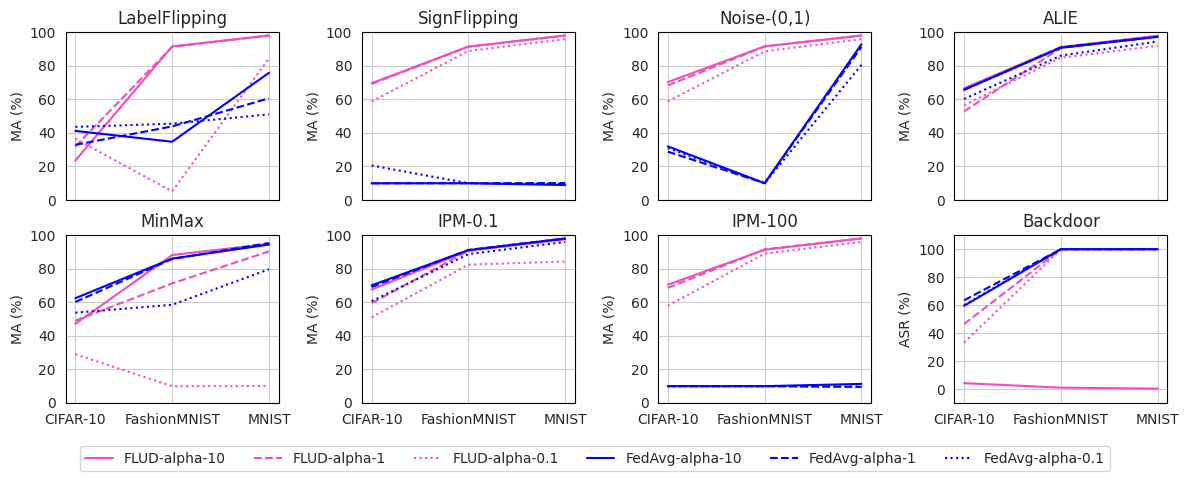

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

# 全局字体设置
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 10

attack_methods = df['attack_method'].unique()
attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise-(0,1)', 'ALIE', 'MinMax', 'IPM-0.1', 'IPM-100', 'Backdoor']

# FLUD对应橙色, FedAvg对应蓝色, 建立颜色映射
colors = ['#F14CC1', 'blue']

# 不同的alpha对应不同线型
linestyles = ['-', '--', ':']


sns.set_style("whitegrid")
sns.set_palette("bright")


# 画8种攻击方法作为8个子图, 每个子图中有3个横坐标为CIFAR10, FashionMNIST, MNIST
fig, axes = plt.subplots(2, 4, figsize=(12, 4.8))


for i, attack_method in enumerate(attack_methods):
    ax = axes[i//4, i%4]
    # 如果攻击方法不是 Backdoor, 则画出FLUD在不同数据集上, 不同alpha的准确率, 以及FedAvg在不同数据集上, 不同alpha的准确率
    if attack_method != 'Backdoor':
        # 筛选出attack_method为attack_method的行
        df_attack_method = df[df['attack_method'] == attack_method]
        # x 坐标轴依次为 CIFAR-10, FashionMNIST, MNIST
        x = ['CIFAR-10', 'FashionMNIST', 'MNIST']
        # y 坐标轴为 acc_top_1
        
        # 取出 FLUD 的df行
        df_FLUD = df_attack_method[df_attack_method['defense_method'] == 'FLUD']
        # 对于不同的alpha, 画出不同的线, 每条线由三个点组成(对应三个数据集)
        for a_id, alpha in enumerate([10, 1, 0.1]):
            y_row = df_FLUD[df_FLUD['alpha'] == alpha]
            
            # 依次取出CIAR-10, FashionMNIST, MNIST的准确率
            # y = [y_row[y_row['dataset'] == dataset]['acc_top_1'] for dataset in x]
            # ax.plot(x, y, label=f'FLUD-alpha-{alpha}', color=colors[0], linestyle=linestyles[a_id])

            # 用sns画图
            # 确认y_row的行数, 对应三个数据集
            # print(y_row.shape[0])
            # 对数据集排序, 按照 CIFAR-10, FashionMNIST, MNIST的顺序
            y_row = y_row.sort_values(by='dataset')
            sns.lineplot(data=y_row, x='dataset', y='acc_top_1', ax=ax, label=f'FLUD-alpha-{alpha}', color=colors[0], linestyle=linestyles[a_id])

            
        # 取出 FedAvg 的df行
        df_FedAvg = df_attack_method[df_attack_method['defense_method'] == 'FedAvg']
        # 对于不同的alpha, 画出不同的线, 每条线由三个点组成(对应三个数据集)
        for a_id, alpha in enumerate([10, 1, 0.1]):
            y_row = df_FedAvg[df_FedAvg['alpha'] == alpha]

            # 依次取出CIAR-10, FashionMNIST, MNIST的准确率
            # y = [y_row[y_row['dataset'] == dataset]['acc_top_1'] for dataset in x]
            # ax.plot(x, y, label=f'FedAvg-alpha-{alpha}', color=colors[1], linestyle=linestyles[a_id])
            
            y_row = y_row.sort_values(by='dataset')
            sns.lineplot(data=y_row, x='dataset', y='acc_top_1', ax=ax, label=f'FedAvg-alpha-{alpha}', color=colors[1], linestyle=linestyles[a_id])
            # 不显示dataset
            ax.set_xlabel('')
        # 设置y轴的范围
        ax.set_ylim(0, 100)
        ax.set_ylabel('MA (%)')
        
        # 添加标题
        ax.set_title(attack_method)


        # 添加边框
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        # 设置边框的颜色
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        
        ax.get_legend().remove()
        # 设置字体


    # 如果攻击方法是 Backdoor, 则画出FLUD在不同数据集上, 不同alpha的test_asr, 以及FedAvg在不同数据集上, 不同alpha的test_asr
    else:
        # 筛选出attack_method为attack_method的行
        df_attack_method = df[df['attack_method'] == attack_method]
        # x 坐标轴依次为 CIFAR-10, FashionMNIST, MNIST
        x = ['CIFAR-10', 'FashionMNIST', 'MNIST']
        # y 坐标轴为 test_asr
        
        # 取出 FLUD 的df行
        df_FLUD = df_attack_method[df_attack_method['defense_method'] == 'FLUD']
        # 对于不同的alpha, 画出不同的线, 每条线由三个点组成(对应三个数据集)
        for a_id, alpha in enumerate([10, 1, 0.1]):
            y_row = df_FLUD[df_FLUD['alpha'] == alpha]
            # 依次取出CIAR-10, FashionMNIST, MNIST的准确率
            # y = [y_row[y_row['dataset'] == dataset]['test_asr'] for dataset in x]
            # ax.plot(x, y, label=f'FLUD-alpha-{alpha}', color=colors[0], linestyle=linestyles[a_id])

            y_row = y_row.sort_values(by='dataset')
            sns.lineplot(data=y_row, x='dataset', y='test_asr', ax=ax, label=f'FLUD-alpha-{alpha}', color=colors[0], linestyle=linestyles[a_id])

        # 取出 FedAvg 的df行
        df_FedAvg = df_attack_method[df_attack_method['defense_method'] == 'FedAvg']
        # 对于不同的alpha, 画出不同的线, 每条线由三个点组成(对应三个数据集)
        for a_id, alpha in enumerate([10, 1, 0.1]):
            y_row = df_FedAvg[df_FedAvg['alpha'] == alpha]
            
            # 依次取出CIAR-10, FashionMNIST, MNIST的准确率
            # y = [y_row[y_row['dataset'] == dataset]['test_asr'] for dataset in x]
            # ax.plot(x, y, label=f'FedAvg-alpha-{alpha}', color=colors[1], linestyle=linestyles[a_id])

            y_row = y_row.sort_values(by='dataset')
            sns.lineplot(data=y_row, x='dataset', y='test_asr', ax=ax, label=f'FedAvg-alpha-{alpha}', color=colors[1], linestyle=linestyles[a_id])
            # 不显示dataset
            ax.set_xlabel('')
        # 设置y轴的范围
        ax.set_ylim(-10, 110)
        ax.set_ylabel('ASR (%)')
        

        # 添加标题
        ax.set_title(attack_method)
        # 添加边框
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        # 设置边框的颜色
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')

        ax.get_legend().remove()

    # 如果i<4, 说明是第一行, 需要不显示xlabel, 抹去刻度上的数字
    if i < 4:
        ax.set_xlabel('')
        ax.set_xticklabels([])

# 在总图的下方显示图例, 注意每个图例的名字不要重复
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7)
# 调整子图之间的间距
plt.tight_layout()

# 调整legend的位置, 让他更往下一些
plt.subplots_adjust(bottom=0.15, hspace=0.21)
# plt.savefig(f'{dataset_names[0]}_8_subfigs.pdf')
plt.show()


        
    
